# Deep Learning Based Sentiment and Sarcasm Analysis

In this jupyter notebook, we use widely available and free datasets that can be found online to train our deep neural network architecture.  The neural network architecture is multifaceted and employs different layers to serve an NLP based application.  The purpose of this architecture is being able to detect sentiment as well as detect the presence of sarcasm (sentence level).  In the notebook below we will be detailing how the architecture works by going through each of the following stages:

1. Selecting and Importing Training Data
2. Preprocessing the Training Data
3. Creating the Deep Learning Architecture Model
4. Training the Model
5. Using Model for New Text

## 1. Selecting and Importing Training Data

Below we import all the relevant libraries that we'll possibly need.

### i. Import libraries


In [ ]:
import re
import matplotlib.pyplot as plt
import string
from nltk.corpus import stopwords
import nltk
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from nltk.tokenize.treebank import TreebankWordDetokenizer
from collections import Counter
from wordcloud import WordCloud
from gensim.utils import simple_preprocess
import gensim
from sklearn.model_selection import train_test_split
import pickle
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt 
import tensorflow as tf
import keras
import numpy as np
import pandas as pd
from sklearn.utils import resample
from sklearn.utils import shuffle
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from nltk.stem.porter import PorterStemmer
stemmer = PorterStemmer()
nltk.download('stopwords')
stopwords_english = stopwords.words('english')

In [ ]:
from keras.models import Sequential
from keras import layers 
from keras.optimizers import RMSprop,Adam
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras import regularizers
from keras import backend as K
from keras.callbacks import ModelCheckpoint
from keras.models import Model

from IPython.display import Image, clear_output

### ii. Selecting the Datasets

Generally speaking, the larger a dataset is for traininng purposes the more attractive it is compared to small datasets.  The reason being it gives the user more freedom to control the amount of data that the model will be trained on.  That aspect is important because if the model is trained on too much data it can cause overfitting, but if there's too little data then the model wouldn't have the chance to minimize it's loss function sufficiently.

With that being said, we've chosen two datasets both of which are 5 star reviews.  The first one is from yelp and the second one is from amazon.  The idea here is that when someone gives a rating they're essentially labeling the sentiment of the review they leave behind.  That can be exploited to train a sentiment analysis NN model.  The data used here is sufficiently large while also being widely available on the internet for free via kaggle.

As for the sarcasm training dataset, we're using reddit sarcastic comments as well as the onion headlines.

### iii. Load Dataset (Load your dataset here)

In [ ]:
#SENTIMENT DATASET

# Load the yelp review dataset from local file path
df_yelp = pd.read_csv('data/yelp.csv')

# Get rid of all the irrelevant columns that we won't be needing leaving behind just the content and the labels
df_yelp.drop(df_yelp.columns[[0,1,2,5,6,7,8,9]], axis=1, inplace=True)

# Renaming the two columns left to something descriptive
df_yelp.columns = ['label', 'clean_comment']

#--------------------------------------------------------------------------

# Load the amazon review dataset from local file path
df_amazon = pd.read_csv('data/amazonreviews.csv')

# Get rid of all the irrelevant columns that we won't be needing leaving behind just the content and the labels
df_amazon.drop(df_amazon.columns[[0,1,2,3,4,5,7,8]], axis=1, inplace=True)

# Renaming the two columns left to something descriptive
df_amazon.columns = ['label', 'clean_comment']

#--------------------------------------------------------------------------

# Mix the two review datasets
df_sentiment = pd.concat([df_yelp, df_amazon])

# Delete any rows with garbage labels
df_sentiment = df_sentiment.drop(df_sentiment[(df_sentiment["label"] != 1) & (df_sentiment["label"] != 2) & (df_sentiment["label"] != 3) & (df_sentiment["label"] != 4) & (df_sentiment["label"] != 5)].index)

# Cast the labels as integers
df_sentiment["label"].astype('int')


0         5
1         5
2         4
3         5
4         5
         ..
568449    5
568450    2
568451    5
568452    5
568453    5
Name: label, Length: 578454, dtype: int64

In [ ]:
# SARCASM DATASET

# Load the reddit comments dataset from local file path
df_reddit = pd.read_csv('data/train-balanced-sarcasm.csv')

# Get rid of all the irrelevant columns that we won't be needing leaving behind just the content and the labels
df_reddit.drop(df_reddit.columns[[2,3,4,5,6,7,8,9]], axis=1, inplace=True)

# Renaming the two columns left to something descriptive
df_reddit.columns = ['label','clean_comment']

# Cast the labels as integers
df_reddit["label"].astype('int')

#--------------------------------------------------------------------------

# Load the json onion headlines dataset from local file path
df_onion = pd.read_json('archive/Sarcasm_Headlines_Dataset.json', lines = True)

# Get rid of all the irrelevant columns that we won't be needing leaving behind just the content and the labels
df_onion.drop(df_onion.columns[[0]], axis=1, inplace=True)

# Renaming the two columns left to something descriptive
df_onion.columns = ['clean_comment','label']

# Delete any rows with garbage labels
df_onion = df_onion.drop(df_onion[(df_onion["label"] != 0) & (df_onion["label"] != 1)].index)

# Cast the labels as integers
df_onion["label"].astype('int')

# Mix the two sarcasm datasets into a master sarcasm dataframe
df_sarcasm = pd.concat([df_reddit, df_onion])

# Cast the labels as integers
df_sarcasm["label"].astype('int')


0        0
1        0
2        0
3        0
4        0
        ..
26704    0
26705    0
26706    0
26707    0
26708    0
Name: label, Length: 1037535, dtype: int64

## 2. Preprocessing the Training Data

### i. Upsample Dataset

The idea of upsampling is ensuring that all data labels in our dataset have the same count.  Naturally, you wouldn't expect randomly sampled comments and reviews from around the internet to contain a uniform distribution of labels, where usually positive sentiment statements are more common.  This phenomenon needs to be addressed in order to reduce bias in the training dataset.  To do that, we use upsampling which ensures all labels in our dataset have the same count.

In [ ]:
# Separate the data based on their labels
data_majority = df_sentiment[df_sentiment['label'] == 5]
data_minority = df_sentiment[df_sentiment['label'] == 2]
data_minority1 = df_sentiment[df_sentiment['label'] == 3]
data_minority2 = df_sentiment[df_sentiment['label'] == 4]
data_minority3 = df_sentiment[df_sentiment['label'] == 1]

# Calculate bias
bias = data_minority.shape[0]/data_majority.shape[0]

# Mix around the data
train = pd.concat([data_majority.sample(frac=1,random_state=200),
         data_minority.sample(frac=1,random_state=200), data_minority1.sample(frac=1,random_state=200),  data_minority2.sample(frac=1,random_state=200), data_minority3.sample(frac=1,random_state=200)])

#Seperate the data based on their labels again
data_majority = train[train['label'] == 5]
data_minority = train[train['label'] == 2]
data_minority1 = train[train['label'] == 3]
data_minority2 = train[train['label'] == 4]
data_minority3 = train[train['label'] == 1]

#show the count of different labels
print("majority class before upsample:",data_majority.shape)
print("minority class before upsample:",data_minority.shape)
print("minority class2 before upsample:",data_minority1.shape)
print("minority class3 before upsample:",data_minority2.shape)
print("minority class4 before upsample:",data_minority3.shape)

# Upsample minority class
data_minority_upsampled = resample(data_minority, 
                                 replace=True,     # sample with replacement
                                 n_samples= data_majority.shape[0],    # to match majority class
                                 random_state=123) # reproducible results
data_minority_upsampled1 = resample(data_minority1, 
                                 replace=True,     # sample with replacement
                                 n_samples= data_majority.shape[0],    # to match majority class
                                 random_state=123) # reproducible results
data_minority_upsampled2 = resample(data_minority2, 
                                 replace=True,     # sample with replacement
                                 n_samples= data_majority.shape[0],    # to match majority class
                                 random_state=123) # reproducible results
data_minority_upsampled3 = resample(data_minority3, 
                                 replace=True,     # sample with replacement
                                 n_samples= data_majority.shape[0],    # to match majority class
                                 random_state=123) # reproducible results

# Combine majority class with upsampled minority class
data_upsampled_sentiment = pd.concat([data_majority, data_minority_upsampled, data_minority_upsampled1, data_minority_upsampled2, data_minority_upsampled3])
 
# Display new class counts
print("After upsampling\n",data_upsampled_sentiment.label.value_counts(),sep = "")


majority class before upsample: (366459, 2)
minority class before upsample: (30696, 2)
minority class2 before upsample: (44101, 2)
minority class3 before upsample: (84181, 2)
minority class4 before upsample: (53017, 2)
After upsampling
label
5    366459
2    366459
3    366459
4    366459
1    366459
Name: count, dtype: int64


In [ ]:
# Separate majority and minority classes
data_majority = df_sarcasm[df_sarcasm['label'] == 0]
data_minority = df_sarcasm[df_sarcasm['label'] == 1]

# Calculate Bias in the data
bias = data_minority.shape[0]/data_majority.shape[0]

# Mix around the data
train = pd.concat([data_majority.sample(frac=1,random_state=200),
         data_minority.sample(frac=1,random_state=200)])

# Print out the labeled data's count
print('Not sarcastic data in training:',(train.label == 0).sum())
print('sarcastic data in training:',(train.label == 1).sum())

# Separate majority and minority classes in training data for upsampling 
data_majority = train[train['label'] == 0]
data_minority = train[train['label'] == 1]


print("majority class before upsample:",data_majority.shape)
print("minority class before upsample:",data_minority.shape)

# Upsample minority class
data_minority_upsampled = resample(data_minority, 
                                 replace=True,     # sample with replacement
                                 n_samples= data_majority.shape[0],    # to match majority class
                                 random_state=123) # reproducible results

# Combine majority class with upsampled minority class
data_upsampled_sarcasm = pd.concat([data_majority, data_minority_upsampled])
 
# Display new class counts
print("After upsampling\n",data_upsampled_sarcasm.label.value_counts(),sep = "")


Not sarcastic data in training: 520398
sarcastic data in training: 517137
majority class before upsample: (520398, 2)
minority class before upsample: (517137, 2)
After upsampling
label
0    520398
1    520398
Name: count, dtype: int64


**Visualize Data**

<Axes: xlabel='count', ylabel='label'>

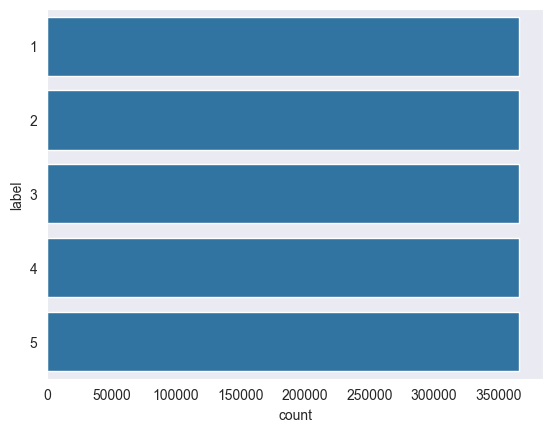

In [ ]:
sns.set_style("dark")

# plot how many labeled data there are from the upsampled data
sns.countplot(data_upsampled_sentiment.label.astype('category'))

<Axes: xlabel='count', ylabel='label'>

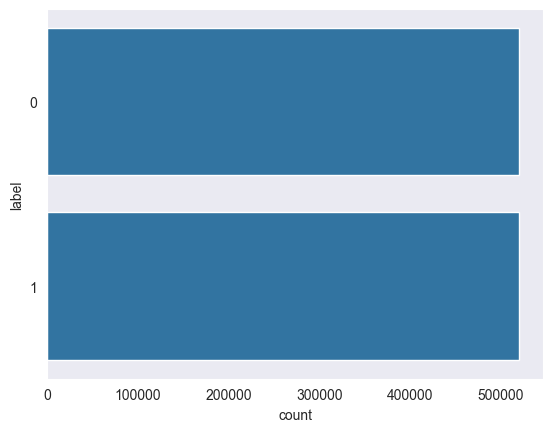

In [ ]:
# plot how many labeled data there are from the upsampled data

sns.countplot(data_upsampled_sarcasm.label.astype('category'))

**Data Pre-process**

In [ ]:

def depure_data(data):
    #Removing URLs with a regular expression
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    data = url_pattern.sub(r'', data)

    # Remove Emails
    data = re.sub('\S*@\S*\s?', '', data)

    # Remove new line characters
    data = re.sub('\s+', ' ', data)

    # Remove distracting single quotes
    data = re.sub("\'", "", data)
        
    return data

def sent_to_words(sentences):
    for sentence in sentences:
        yield gensim.utils.simple_preprocess(str(sentence), deacc=True)  # deacc=True removes punctuations

def preprocess(tweet, remove_stopwords=True, lemmatize=True):
    temp = [] 
    # Splitting pd.Series to list
    data_to_list = tweet['clean_comment'].values.tolist()
    for i in range(len(data_to_list)):
        temp.append(depure_data(data_to_list[i]))  
    data_words = list(sent_to_words(temp))
    # Remove stopwords
    if remove_stopwords:
        data_words = [[word for word in doc if word not in gensim.parsing.preprocessing.STOPWORDS] for doc in data_words]
    
    # Lemmatize words
    if lemmatize:
        lemmatizer = WordNetLemmatizer()
        data_words = [[lemmatizer.lemmatize(word) for word in doc] for doc in data_words]
        
    data = []
    for i in range(len(data_words)):
        data.append(TreebankWordDetokenizer().detokenize(data_words[i]))
    del data_words, temp, i
    return data


In [ ]:
#import string type casting library
from pandas.api.types import is_string_dtype

display(data_upsampled_sentiment)

#cast all text as string to avoid any problems in processing the data later
data_upsampled_sentiment['clean_comment'] = data_upsampled_sentiment['clean_comment'].astype(str)
data_upsampled_sarcasm['clean_comment'] = data_upsampled_sarcasm['clean_comment'].astype(str)

,label,clean_comment
551146,5,"These are raw, whole, natural, cashews. Much l..."
341934,5,"We were the grind your own beans, french press..."
260284,5,I have had celiac for over 7 years. I found o...
63655,5,Okay I am not a hot coffee person. But iced co...
199091,5,I have a three year old and a seven year old a...
...,...,...
217156,1,I have been drinking Pero ever since I was a l...
402342,1,"Well, it looks like they took my review off fr..."
51701,1,I ordered this lavender to use in ice cream. B...
446020,1,There is very little meat in this food and the...


In [ ]:
import nltk
nltk.download('wordnet')

#run the text data through the previously defined preprocessing function
#this removes commas, periods and other useless symbols as well as links
#keeping only meaningful words
sarcasm_data = preprocess(data_upsampled_sarcasm)
sentiment_data = preprocess(data_upsampled_sentiment)

[nltk_data] Downloading package wordnet to /Users/Ahmad/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


**Tokenize word**

In [ ]:
#max amount of words in our tokenizer library
max_words = 5000

#maximum number of words in a sentence
max_len = 200

data_sentiment = sentiment_data

#instantiate the tokenizer object
tokenizer_sentiment = Tokenizer(num_words=max_words)

#create a tokenized library based on the sentiment data
#this creates an indexed list library of the top 5000 most common
#words in the data_sentiment variable
tokenizer_sentiment.fit_on_texts(data_sentiment)

#turns all the sentences in the data_sentiment variable into numbers
#based on their index in the tokenizer object
sequences_sentiment = tokenizer_sentiment.texts_to_sequences(data_sentiment)

#this adds 0s as filler to pad each sentence to make it "200" words even if the sentences 
# are under 200 words because the NN architecture expects 200 word sentences 
tweets_sentiment = pad_sequences(sequences_sentiment, maxlen=max_len, truncating='post')

#---------------------------------------------------------------------------------------------

data_sarcasm = sarcasm_data

#instantiate the tokenizer object
tokenizer_sarcasm = Tokenizer(num_words=max_words)

#create a tokenized library based on the sarcasm data
#this creates an indexed list library of the top 5000 most common
#words in the data_sarcasm variable
tokenizer_sarcasm.fit_on_texts(data_sarcasm)

#turns all the sentences in the data_sarcasm variable into numbers
#based on their index in the tokenizer object
sequences_sarcasm = tokenizer_sarcasm.texts_to_sequences(data_sarcasm)

#this adds 0s as filler to pad each sentence to make it "200" words even if the sentences 
# are under 200 words because the NN architecture expects 200 word sentences 
tweets_sarcasm = pad_sequences(sequences_sarcasm, maxlen=max_len, truncating='post')

tweets_sentiment, tweets_sarcasm

(array([[   0,    0,    0, ...,   23,  125,  108],
        [   0,    0,    0, ..., 1108,  125,  108],
        [   0,    0,    0, ...,   68,   38,   48],
        ...,
        [   0,    0,    0, ...,  390, 1084,  501],
        [   0,    0,    0, ...,    8,  222,  533],
        [   0,    0,    0, ...,  121,  125,  538]], dtype=int32),
 array([[   0,    0,    0, ...,    0,   69,   22],
        [   0,    0,    0, ...,  217,   93, 1317],
        [   0,    0,    0, ...,    0,    0,   22],
        ...,
        [   0,    0,    0, ..., 1346, 1818,  128],
        [   0,    0,    0, ...,    0,    0,   86],
        [   0,    0,    0, ...,   57,   24, 2159]], dtype=int32))

In [ ]:
#show an example of what a tokenized and padded sentence looks like
display(tweets_sentiment[0])

#what the tokenizer object dictionary look like with each index and its
#respective word where the first word is the most common and so on.
tokenizer_sentiment.word_index

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,   

{'br': 1,
 'like': 2,
 'taste': 3,
 'product': 4,
 'good': 5,
 'flavor': 6,
 'coffee': 7,
 'food': 8,
 'tea': 9,
 'great': 10,
 'dont': 11,
 'love': 12,
 'dog': 13,
 'time': 14,
 'cup': 15,
 'bag': 16,
 'little': 17,
 'im': 18,
 'buy': 19,
 'box': 20,
 'better': 21,
 'amazon': 22,
 'price': 23,
 'use': 24,
 'tried': 25,
 'try': 26,
 'water': 27,
 'eat': 28,
 'ive': 29,
 'chocolate': 30,
 'drink': 31,
 'cat': 32,
 'think': 33,
 'sugar': 34,
 'day': 35,
 'way': 36,
 'treat': 37,
 'brand': 38,
 'bought': 39,
 'ingredient': 40,
 'thing': 41,
 'didnt': 42,
 'sweet': 43,
 'know': 44,
 'store': 45,
 'bit': 46,
 'got': 47,
 'best': 48,
 'bad': 49,
 'review': 50,
 'order': 51,
 'year': 52,
 'want': 53,
 'lot': 54,
 'bar': 55,
 'thought': 56,
 'pack': 57,
 'free': 58,
 'star': 59,
 'chip': 60,
 'package': 61,
 'doesnt': 62,
 'work': 63,
 'ordered': 64,
 'nice': 65,
 'mix': 66,
 'come': 67,
 'different': 68,
 'sure': 69,
 'smell': 70,
 'small': 71,
 'need': 72,
 'quality': 73,
 'pretty': 74,
 'st

**Label encoding**

In [ ]:
#show size of upsampled sarcasm data
labels_sarcasm  = data_upsampled_sarcasm[['label']].values
len(labels_sarcasm), len(tweets_sarcasm)

(1040796, 1040796)

In [ ]:
#Label encoding

#this section turns the labels from being 1,2,3,4,5 for the sentiment analysis
#to being hot encoded arrays so that they can be treated as the output data for training and testing
labels_sentiment = np.array(data_upsampled_sentiment['label'])
y = []
for i in range(len(labels_sentiment)):
    if labels_sentiment[i] == 1:
        y.append(0)
    if labels_sentiment[i] == 2:
        y.append(1)
    if labels_sentiment[i] == 3:
        y.append(2)
    if labels_sentiment[i] == 4:
        y.append(3)
    if labels_sentiment[i] == 5:
        y.append(4)
y = np.array(y)
print(y)
labels_sentiment = tf.keras.utils.to_categorical(y, 5, dtype="float32")
del y
len(labels_sentiment)

[4 4 4 ... 0 0 0]


1832295

In [ ]:
#this is what the hot encoded data labeling looks like
#the star rating is selected with a 1 flag while all the other ones
#are 0, so for example 3 stars would be [0,0,1,0,0]
display(labels_sentiment)

array([[0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       ...,
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.]], dtype=float32)

**Train_test_split**

In [ ]:
#Splitting the data for training and testing purposes

X_train_sarcasm, X_test_sarcasm, y_train_sarcasm, y_test_sarcasm = train_test_split(tweets_sarcasm,labels_sarcasm, test_size=0.1,random_state=1, shuffle = True)
print (len(X_train_sarcasm),len(X_test_sarcasm),len(y_train_sarcasm),len(y_test_sarcasm))

X_train_sentiment, X_test_sentiment, y_train_sentiment, y_test_sentiment = train_test_split(tweets_sentiment,labels_sentiment, test_size=0.1,random_state=1, shuffle = True)
print (len(X_train_sentiment),len(X_test_sentiment),len(y_train_sentiment),len(y_test_sentiment))

936716 104080 936716 104080
1649065 183230 1649065 183230


In [ ]:
#import the 200 dimensional pre-trained word2vec gloVe dataset
EMBEDDING_FILE = 'glove.twitter.27B/glove.twitter.27B.200d.txt'

def get_coefs(word, *arr): 
    return word, np.asarray(arr, dtype='float32')

#this basically parses the gloVe word2vec embeddings file by going line by line
#splitting up the words and numbers then turning it into a dictionary item which will
#be later used to create the embedding matrices
embeddings_index = dict(get_coefs(*o.rstrip().rsplit(' ')) for o in open(EMBEDDING_FILE, encoding = 'utf8'))



In [ ]:
#this is what one item from the embedding dictionary looks like
display(list(embeddings_index.items())[15])

('you',
 array([ 1.9640e-01,  6.7153e-01,  6.2976e-03,  2.5359e-01, -4.2097e-01,
         3.8490e-01,  1.0378e+00, -1.8536e-01, -5.4244e-02, -1.0856e-01,
         1.2146e-01,  4.7692e-02, -9.3228e-01, -2.7192e-01, -3.5060e-01,
         1.1069e-01, -5.5099e-02, -7.9658e-02,  1.1767e-02,  1.4395e-01,
        -2.5917e-02, -1.8253e-01,  2.5691e-02,  1.9619e-01,  1.0334e-01,
         1.0731e+00,  4.1992e-01,  1.7083e-01,  9.1596e-01, -4.3398e-01,
         1.6464e-01,  1.2715e-02,  9.5477e-02,  1.4490e-01, -2.9652e-01,
        -1.0642e-01,  9.8389e-02,  1.7937e-01,  2.3289e-01, -2.2209e-01,
         8.7770e-02, -1.8005e-01,  3.8678e-01, -3.2059e-02,  1.2020e-01,
        -4.1741e-01,  2.6827e-01, -1.9769e-01,  2.1976e-02, -2.3585e-01,
         1.4789e-01,  1.0173e-01, -1.0380e-01, -3.1954e-01,  6.3308e-01,
        -5.1142e-02, -5.3209e-02,  2.9378e-01, -5.4395e-02,  4.3346e-05,
         2.5585e-01, -1.8048e-01, -2.7030e-01,  7.7783e-03,  6.3585e-01,
         1.4869e-01, -1.0854e-01, -2.4726e-

In [ ]:
#turns the embeddings dictionary into a matrix
all_embs = np.stack(list(embeddings_index.values()))

#get the mean and standard deviation of the embedding values
emb_mean,emb_std = all_embs.mean(), all_embs.std()

#get how many dimensions we're using
embed_size = all_embs.shape[1]

# the ordered dictionary of words based on how often they show up in the sentiment data
word_index = tokenizer_sentiment.word_index

# how many usable words do we have
nb_words = min(max_words, len(word_index))

#### change below line if computing normal stats is too slow

# create an embedding matrix of size nb_words x embed_size 
embedding_matrix_sentiment = embedding_matrix_sentiment = np.random.normal(emb_mean, emb_std, (nb_words, embed_size))

# fill in the embedding_matrix_sentiment matrix with gloVe data in the same order of the
# sentiment tokenizer object so that it can be later accessed based on the tokenizer index
for word, i in word_index.items():
    if i >= max_words: continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None: embedding_matrix_sentiment[i-1] = embedding_vector

In [ ]:
#turns the embeddings dictionary into a matrix
all_embs = np.stack(list(embeddings_index.values()))

#get the mean and standard deviation of the embedding values
emb_mean,emb_std = all_embs.mean(), all_embs.std()

#get how many dimensions we're using
embed_size = all_embs.shape[1]

# the ordered dictionary of words based on how often they show up in the sarcasm datta
word_index = tokenizer_sarcasm.word_index

# how many usable words do we have
nb_words = min(max_words, len(word_index))

####change below line if computing normal stats is too slow

# create an embedding matrix of size nb_words x embed_size 
embedding_matrix_sarcasm = embedding_matrix_sarcasm = np.random.normal(emb_mean, emb_std, (nb_words, embed_size))

# fill in the embedding_matrix_sentiment matrix with gloVe data in the same order of the
# sarcasm tokenizer object so that it can be later accessed based on the tokenizer index
for word, i in word_index.items():
    if i >= max_words: continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None: embedding_matrix_sarcasm[i-1] = embedding_vector

**Machine Learning Algorithm**

In [ ]:
# create an embedding layer for sentiment
embedding_layer1 = layers.Embedding(nb_words, output_dim=200, input_length=max_len, weights = [embedding_matrix_sentiment], trainable = True)

# create an embedding layer for sarcasm
embedding_layer2 = layers.Embedding(nb_words, output_dim=200, input_length=max_len, weights = [embedding_matrix_sarcasm], trainable = True)

# create an input layer for sentiment
sequence_input1 = layers.Input(shape=(max_len,), name='sentiment_input')

# create an input layer for sarcasm
sequence_input2 = layers.Input(shape=(max_len,), name='sarcasm_input')

# connect the input layer with embedding layer
embedded_sequences1 = embedding_layer1(sequence_input1)
embedded_sequences2 = embedding_layer2(sequence_input2)

#sentiment branch
nn1 = layers.Bidirectional(layers.LSTM(units=20 , dropout = 0.6))(embedded_sequences1)
nn1 = layers.Dense(256, activation="relu")(nn1)
nn1 = layers.Dropout(rate=0.4)(nn1)
nn1 = layers.Dense(32, activation="relu")(nn1)
nn1 = layers.Dropout(rate=0.4)(nn1)

#sarcasm branch
nn2 = layers.Bidirectional(layers.LSTM(units=20 ,dropout = 0.6))(embedded_sequences2)
nn2 = layers.Dense(256, activation="relu")(nn2)
nn2 = layers.Dropout(rate=0.4)(nn2)
nn2 = layers.Dense(32, activation="relu")(nn2)
nn2 = layers.Dropout(rate=0.4)(nn2)

In [ ]:
# create the output layers
sentiment_branch = layers.Dense(5, activation='softmax', name='sentiment_output')(nn1)
sarcasm_branch = layers.Dense(1, activation='sigmoid', name='sarcasm_output')(nn2)

In [ ]:
# instantiate the model and define the inputs and outputs
model = Model(inputs = [sequence_input1, sequence_input2], outputs = [sentiment_branch, sarcasm_branch])
model.summary()

In [ ]:
# pick RMSoptimizer as the loss function optimization method
opt = keras.optimizers.RMSprop(learning_rate=0.001)

# compile the model where the sentiment uses cateogorial crossentropy based loss function and sarcasm uses binary crossentropy based loss function
model.compile(optimizer=opt, loss={'sentiment_output':'categorical_crossentropy','sarcasm_output':'binary_crossentropy'}, metrics=['acc'])
checkpoint2 = [ModelCheckpoint("weights/with_embedding(LSTM)1.hdf5", monitor='val_sentiment_output_acc', verbose=1,save_best_only=True, mode='auto', period=1,save_weights_only=False)]

In [ ]:
# a class that plots the loss function progress after every epoch

class PlotProgress(keras.callbacks.Callback):
    
    def __init__(self, entity='loss'):
        self.entity = entity
        
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        
        self.fig = plt.figure()
        
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('{}'.format(self.entity)))
        self.val_losses.append(logs.get('val_{}'.format(self.entity)))
        self.i += 1
        
        clear_output(wait=True)
        fig = plt.figure()
        plt.plot(self.x, self.losses, label= 'training_loss', color = 'Black')
        plt.plot(self.x, self.val_losses, label= 'validation_loss', ls = ':', color = 'Black')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        fig.patch.set_facecolor('white')
        
        #fig.patch.set_alpha(0.0)
        plt.grid()
        plt.legend()
        plt.show();

In [ ]:
# instantiate the plot progress class to be used while we train the model
plot_progress = PlotProgress(entity='loss')

# train the model based on the data we have defined earlier and plot the progress as we go
# and detect an exception if we manually stop the cell from running
try:
    model.fit({'sentiment_input': X_train_sentiment,'sarcasm_input':X_train_sarcasm},
              {'sentiment_output': y_train_sentiment, 'sarcasm_output': y_train_sarcasm},
              epochs=10,
              batch_size=128,
              verbose=1,
              callbacks=[plot_progress, checkpoint2],
              validation_split=0.2,
             )
except KeyboardInterrupt:
    pass

In [ ]:
# save the newly trained model so we don't have to train it again when we want to use it
model.save('my_model.h5')

## 1. Running Pepsi and Coke Tweets Through Model

In [ ]:
import pytesseract

pytesseract.pytesseract.tesseract_cmd = '/opt/homebrew/bin/tesseract'

In [ ]:
from PIL import Image
import os
import pandas as pd

tweet_dict = {
    "date": [],
    "content": [],
    "sentiment": [],
    "sarcasm": []
}

for file in os.listdir("coke tweets"):
    if file.endswith(".png") == False:
        continue
    imagepath = "coke tweets/" + file
    image = Image.open(imagepath)

    pixels = image.getdata()
    pixels = list(pixels)
    odating = [pixels[2+i*1200] for i in range(image.size[1])]
    indices = [index for index, key in enumerate(odating) if key == (47,51,54,255)]

    os.mkdir("coke tweets/" + imagepath[12:17])
    directory = "coke tweets/" + imagepath[12:17]

    for i in range(int(len(indices)/2-1)):
        imm = image.crop((0,indices[1+i*2],1200,indices[2+i*2]))
        if imm.size[1] > 65+80:
            imm.save(directory + "/" + str(i) + ".png")

    files = [f for f in os.listdir(directory) if os.path.isfile(os.path.join(directory, f))]



    for file in files:
        image = Image.open(os.path.join(directory, file))
        newim = image.crop((120,65,1200,image.size[1]-80))
        new_sentence = [pytesseract.image_to_string(newim)]
        tokenized_sentence_sentiment = tokenizer_sentiment.texts_to_sequences(new_sentence)
        tokenized_sentence_sarcasm = tokenizer_sarcasm.texts_to_sequences(new_sentence)
        new_padded_sequence_sentiment = pad_sequences(tokenized_sentence_sentiment, maxlen=200)
        new_padded_sequence_sarcasm = pad_sequences(tokenized_sentence_sarcasm, maxlen = 200)
        predictions = model.predict({'sentiment_input': new_padded_sequence_sentiment,'sarcasm_input':new_padded_sequence_sarcasm})

        tweet_dict["date"].append(imagepath[12:17])
        tweet_dict["content"].append(new_sentence[0])
        tweet_dict["sentiment"].append(predictions[0][0].tolist())
        tweet_dict["sarcasm"].append(predictions[1][0][0])



In [ ]:
# save the processed coke tweets data to an csv file for trading usage

df = pd.DataFrame(tweet_dict)

df.to_csv("coke tweets data.csv")

In [ ]:
from PIL import Image
import os

tweet_dict = {
    "date": [],
    "content": [],
    "sentiment": [],
    "sarcasm": []
}

for file in os.listdir("pepsi tweets"):
    if file.endswith(".png") == False:
        continue
    imagepath = "pepsi tweets/" + file
    image = Image.open(imagepath)

    pixels = image.getdata()
    pixels = list(pixels)
    odating = [pixels[2+i*1200] for i in range(image.size[1])]
    indices = [index for index, key in enumerate(odating) if key == (47,51,54,255)]

    os.mkdir("pepsi tweets/" + imagepath[13:18])
    directory = "pepsi tweets/" + imagepath[13:18]

    for i in range(int(len(indices)/2-1)):
        imm = image.crop((0,indices[1+i*2],1200,indices[2+i*2]))
        if imm.size[1] > 65+80:
            imm.save(directory + "/" + str(i) + ".png")

    files = [f for f in os.listdir(directory) if os.path.isfile(os.path.join(directory, f))]



    for file in files:
        image = Image.open(os.path.join(directory, file))
        newim = image.crop((120,65,1200,image.size[1]-80))
        new_sentence = [pytesseract.image_to_string(newim)]
        tokenized_sentence_sentiment = tokenizer_sentiment.texts_to_sequences(new_sentence)
        tokenized_sentence_sarcasm = tokenizer_sarcasm.texts_to_sequences(new_sentence)
        # display(tokenized_sentence_sentiment)
        # display(tokenized_sentence_sarcasm)
        new_padded_sequence_sentiment = pad_sequences(tokenized_sentence_sentiment, maxlen=200)
        new_padded_sequence_sarcasm = pad_sequences(tokenized_sentence_sarcasm, maxlen = 200)
        predictions = model.predict({'sentiment_input': new_padded_sequence_sentiment,'sarcasm_input':new_padded_sequence_sarcasm})

        tweet_dict["date"].append(imagepath[13:18])
        tweet_dict["content"].append(new_sentence[0])
        tweet_dict["sentiment"].append(predictions[0][0].tolist())
        tweet_dict["sarcasm"].append(predictions[1][0][0])



In [ ]:
# save the processed pepsi tweets data to an csv file for trading usage

df = pd.DataFrame(tweet_dict)

df.to_csv("pepsi tweets data.csv")